In [8]:
import tensorflow as tf
from datetime import datetime
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
import concurrent.futures
import seaborn as sns

In [9]:
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import load_img
from keras.models import Sequential, save_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
# Load the pre-trained model
# model = load_model('/kaggle/input/fer-model/tensorflow1/fer/1/fer model.h5')

# Define the emotion dictionary
emotion_dict = {0: 'anger', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise'}
labels = ['Real', 'Deepfake']

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Directory containing video files
DATA_DIR = '/kaggle/input/deepfake-detection-challenge/train_sample_videos'

In [4]:
def load_metadata(metadata_file):
    metadata = pd.read_json(metadata_file)
    metadata = metadata.T    
    video_labels = {}
    for index, row in metadata.iterrows():
        video_labels[f"{index}"] = row['label']
    return video_labels

In [ ]:
metadata_file = DATA_DIR + "/metadata.json"
labels = load_metadata(metadata_file)

In [ ]:
# Function to convert image and predict emotion
def convert_image(image):
    pic = cv2.resize(image, (48, 48))
    pic_rgb = cv2.cvtColor(pic, cv2.COLOR_GRAY2RGB)
    image_arr = np.array([pic_rgb], dtype='float32')
    image_arr /= 255
    prediction = model.predict(image_arr, verbose=None)[0]
    return np.argmax(prediction)

In [ ]:
def process_frame(frame):
    prediction = convert_image(frame)
    return prediction

In [ ]:
def extract_emotions(metadata_file):
    
    df = pd.DataFrame(columns=['video', 'major_emotion', 'label'])
    video_labels = load_metadata(metadata_file)
    
    # Process each video file
    for filename in tqdm(os.listdir(DATA_DIR)):
        if filename.endswith(".mp4"):
            print(filename)
            path = os.path.join(DATA_DIR, filename)  
            cap = cv2.VideoCapture(path)
            emotion_counts = {}
            frame_counter = 0
            label = video_labels[f"{filename}"]

            while cap.isOpened():
                ret, frame = cap.read()
                if ret:
                    if frame_counter % 30 == 0:
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                        with concurrent.futures.ThreadPoolExecutor() as executor:
                            for (x, y, w, h) in faces:
                                roi_gray = gray[y:y + h, x:x + w]
                                frame_processing_task = executor.submit(process_frame, roi_gray)
                                emotion = emotion_dict.get(frame_processing_task.result())
                                if emotion:
                                    emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
                    frame_counter += 1
                else:
                    break
            cap.release()

            # Determine the most frequent emotion
            if emotion_counts:
                major_emotion = max(emotion_counts, key=emotion_counts.get)
                df = df._append({'video': filename, 'major_emotion': major_emotion, 'label': label}, ignore_index=True)
                print('Major Emotion:', major_emotion)
    return df

In [ ]:
# emotions = extract_emotions(metadata_file)

In [ ]:
# # Save DataFrame to CSV
# emotions.to_csv('DFDC emotions.csv', index=False)
# # Display DataFrame
# emotions.head()

In [11]:
emotion_df = pd.read_csv('/kaggle/working/DFDC emotions.csv')

emotion_df.head()

,video,major_emotion,label
0,eivxffliio.mp4,anger,FAKE
1,dwediigjit.mp4,disgust,FAKE
2,asvcrfdpnq.mp4,fear,FAKE
3,dntkzzzcdh.mp4,fear,FAKE
4,dboxtiehng.mp4,fear,FAKE


In [10]:
def split_files(real_files, fake_files):
    
    ## REAL 
    real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)    # test size = 20%
    real_train, real_val = train_test_split(real_train, test_size=0.1, random_state=42)     # validation size = 10% of train (80%) = 8%

    ## FAKE
    fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)   
    fake_train, fake_val = train_test_split(fake_train, test_size=0.1, random_state=42)

    print("TESTING SET (20%)")
    print(f"Real Test Files: {len(real_test)}")
    print(f"Fake Test Files: {len(fake_test)}")

    print("---------------------------------------------")

    print("VALIDATION SET (8%)")
    print(f"Real Validation Files: {len(real_val)}")
    print(f"Fake Validation Files: {len(fake_val)}")

    print("---------------------------------------------")

    print("TRAINING SET (72%)")
    print(f"Real Train Files: {len(real_train)}")
    print(f"Fake Train Files: {len(fake_train)}")

    print("---------------------------------------------")


    train_files = real_train + fake_train
    val_files = real_val + fake_val
    test_files = real_test + fake_test

    # shuffle training data
    np.random.shuffle(train_files)

    print(f"Total Train Files: {len(train_files)}")
    print(f"Total Test Files: {len(test_files)}")
    print(f"Total Validation: {len(val_files)}")
    
    return train_files, test_files, val_files


In [12]:
## PARAMETERS

img_size = 64
seq_length = 50
batch_size = 32

In [13]:
def detect_face(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    #if at least one face detected
    if(len(faces) > 0):
        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            face = img[y:y + h, x:x + w] #crop frame to face
            return face
    else:
        return img #if no face detected use frame as is
#         cv2.imshow("face",faces) 

In [14]:
def load_frames_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_counter = 0
    while True:
        ret, frame = cap.read()
        if ret:
            if frame_counter % 30 == 0: 
                face = detect_face(frame)
                frame = cv2.resize(frame, (img_size, img_size))
                frame = frame.astype('float32') / 255.0
                frames.append(frame)
            frame_counter += 1
        if not ret:
            break
    cap.release()
    
#     print(len(frames))

    # Pad or slice frames to have a consistent sequence length
    if len(frames) < seq_length:
        frames += [np.zeros((img_size, img_size, 3))] * (seq_length - len(frames))
    frames = frames[:seq_length]

    return np.array(frames)

In [15]:
def setup_dataset(files, is_train):
    video_labels = load_metadata(metadata_file)
    frames = []
    labels = []
    for video_file in tqdm(files):
        if video_file.endswith('mp4'):
            video_path = os.path.join(DATA_DIR, video_file)
            vid_frames = load_frames_from_video(video_path)
            label = video_labels[f"{video_file}"]
            print(video_file, label)
            frames.append(vid_frames)
            labels.append(0 if label == 'REAL' else 1)
            
    print(len(frames), len(labels))
    dataset = tf.data.Dataset.from_tensor_slices((frames, labels))
    if is_train:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

## Data Visualization

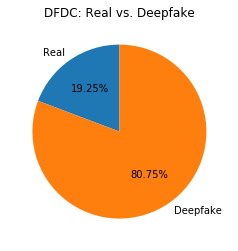

In [13]:
# labeled = emotions['label'].value_counts()

real_videos = emotion_df[(emotion_df["label"] == 'REAL')]["video"].to_list()
fake_videos = emotion_df[(emotion_df["label"] == 'FAKE')]["video"].to_list()

plt.pie([len(real_videos),len(fake_videos)], labels=['Real', 'Deepfake'], autopct='%1.2f%%', startangle=90)

plt.title("DFDC: Real vs. Deepfake")
plt.savefig('DFDC real vs fake.png',bbox_inches='tight')
plt.show()

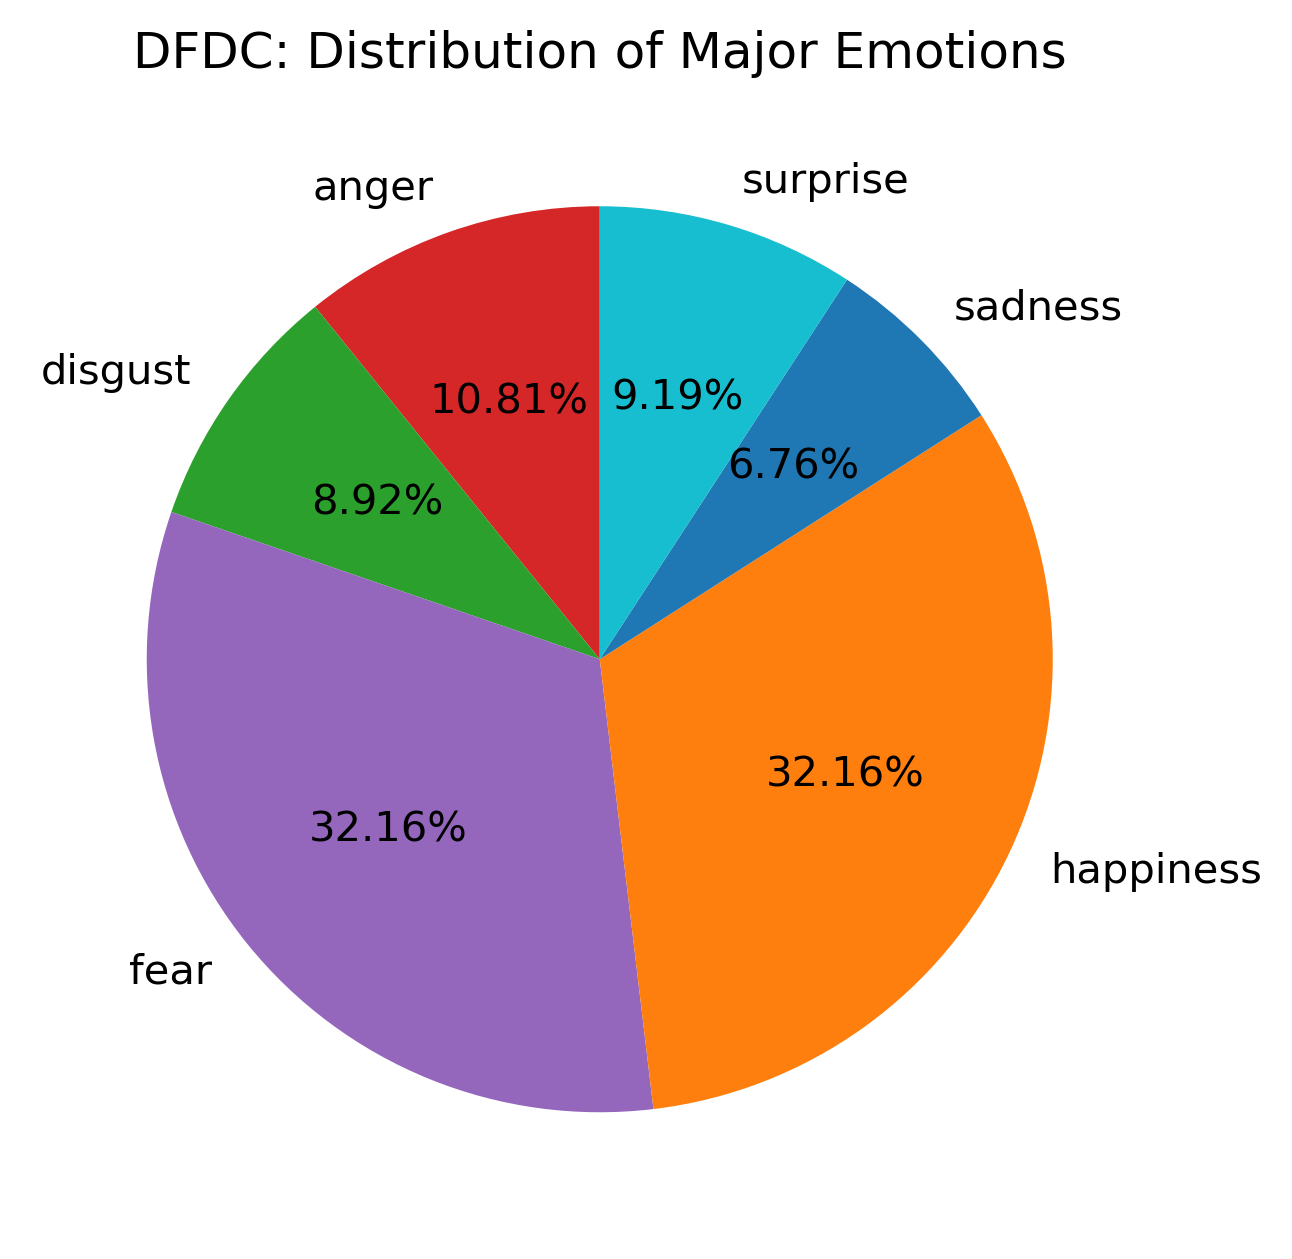

In [42]:
# Plot emotions

colors = ['tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:blue', 'tab:cyan']
plt.figure(figsize=(5, 5), dpi=300)

emo_data = emotion_df['major_emotion'].value_counts().sort_index()#.plot(kind='bar')
plt.pie(emo_data, labels=emo_data.index, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title("DFDC: Distribution of Major Emotions")
# Set the figure size
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.savefig('DFDC emotion distribution.png',bbox_inches='tight')
plt.show()


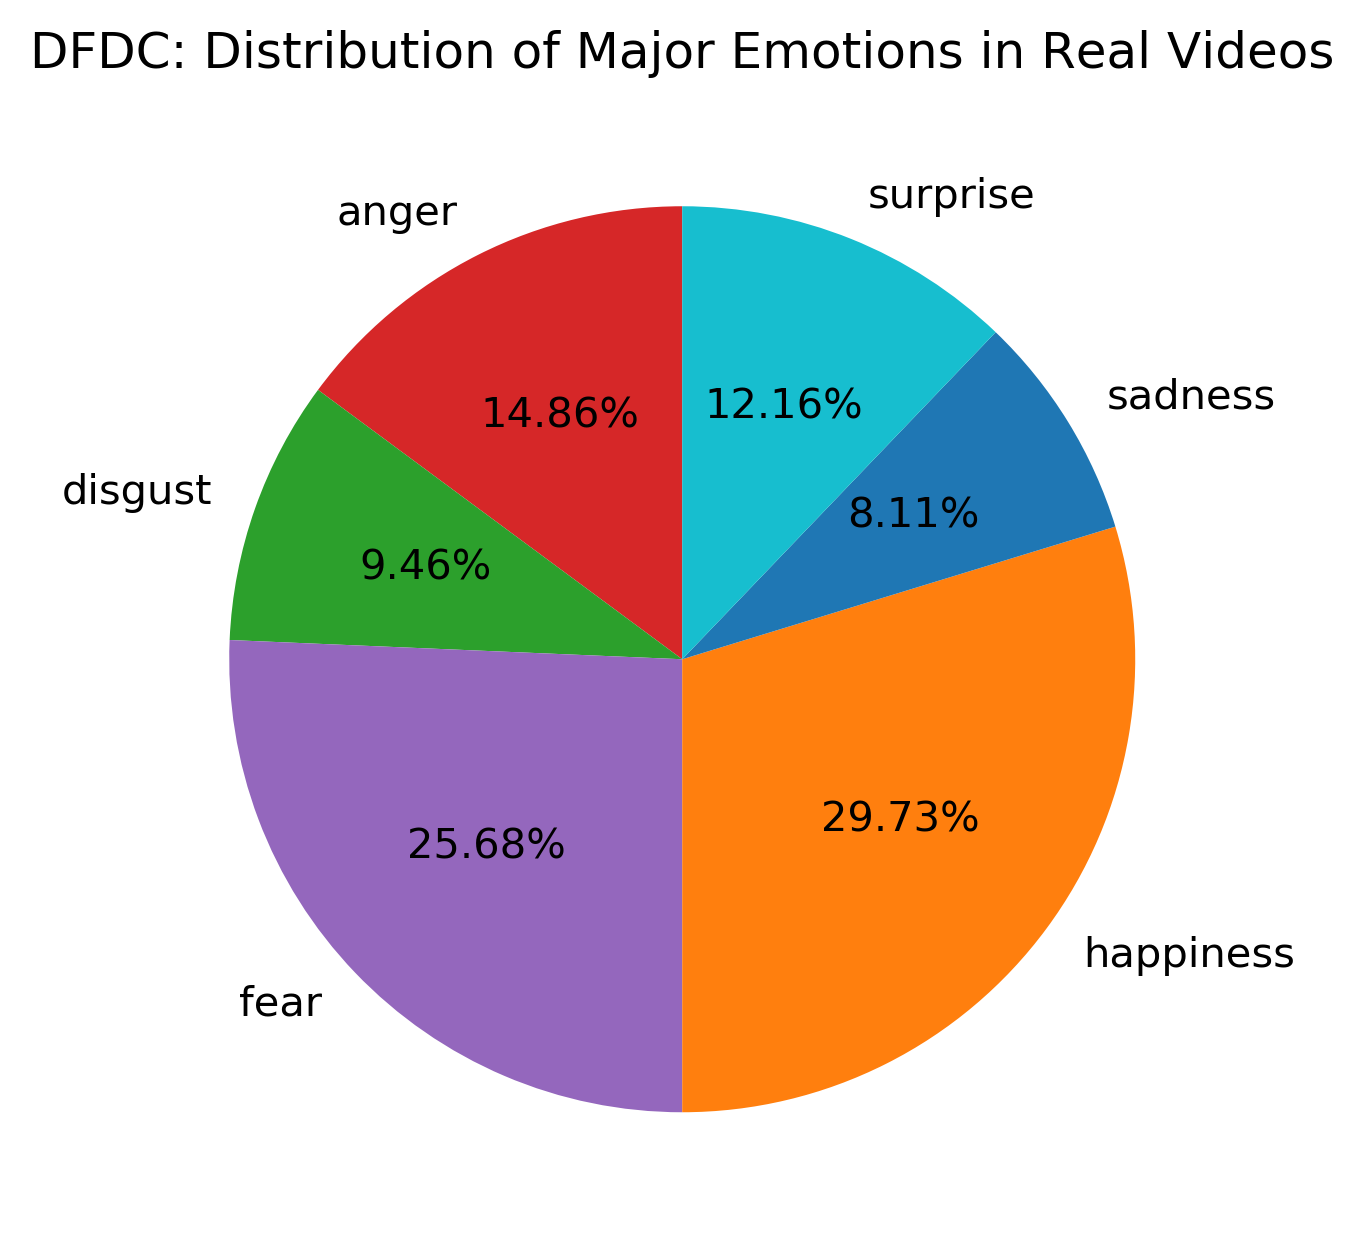

In [44]:
real_emotions = emotion_df[emotion_df["label"] == 'REAL']["major_emotion"].value_counts().sort_index()#.plot(kind='bar')
plt.figure(figsize=(5, 5), dpi=300)

plt.pie(real_emotions, labels=real_emotions.index, autopct='%1.2f%%', startangle=90, colors = colors)
plt.title("DFDC: Distribution of Major Emotions in Real Videos")
plt.savefig('DFDC emotion distribution real .png',bbox_inches='tight')
plt.show()


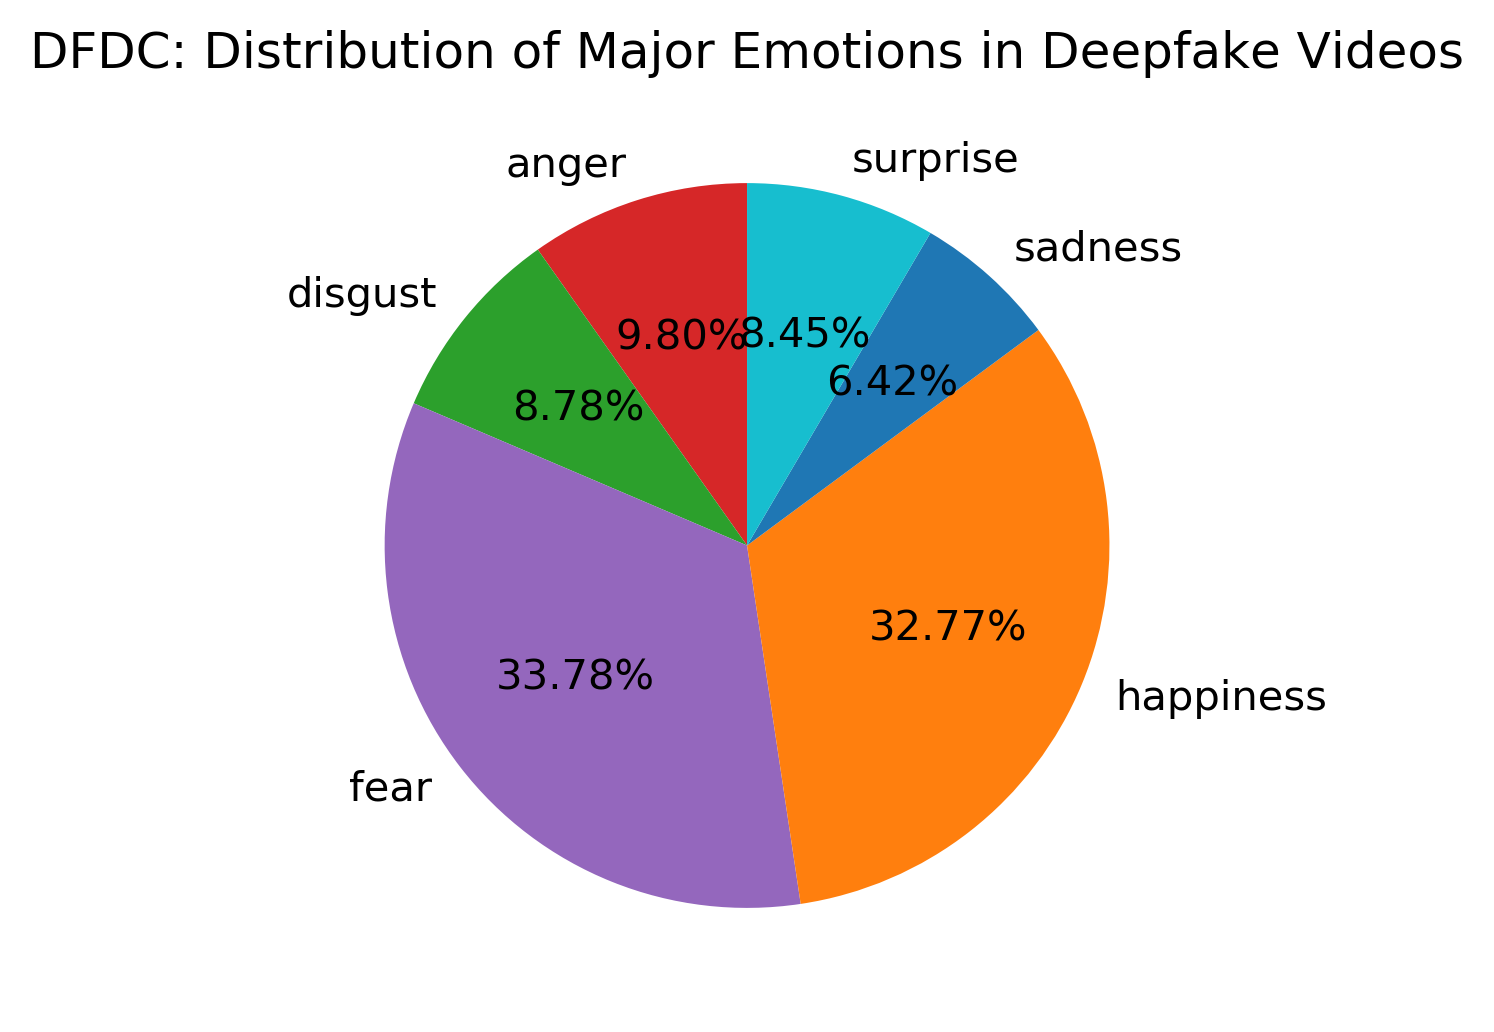

In [47]:
fake_emotions = emotion_df[emotion_df["label"] == 'FAKE']["major_emotion"].value_counts().sort_index()#.plot(kind='bar')
plt.figure(figsize=(4, 4), dpi=300)

plt.pie(fake_emotions, labels=fake_emotions.index, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title("DFDC: Distribution of Major Emotions in Deepfake Videos")
plt.savefig('DFDC emotion distribution fake .png',bbox_inches='tight')
plt.show()


In [ ]:
# Plot emotions
emo_data = emotion_df['major_emotion'].value_counts()

# grouped = emotion_df.groupby(['major_emotion','label']).size()#.reset_index(name='count')
emotion_counts = emotion_df[emotion_df["label"] == 'FAKE']["major_emotion"].value_counts()


# emotions.major_emotion.value_counts().sort_index().plot.bar(title="Distribution of Major Emotions")
plt.pie(emotion_counts, labels=emo_data.index, autopct='%1.2f%%', startangle=90)

# plt.bar(emo_data.index, emo_data, )
#
# grouped.plot(kind='barh')

# plt.xlabel("Emotion")
# plt.ylabel("Videos")

plt.title("Distribution of Major Emotions in Deepfake Videos")
plt.savefig('DFDC emotion distribution fake.png',bbox_inches='tight')
plt.show()



## Training Data (No Emotions)

In [16]:
##### Splitting the dataset into train, validation, and test sets

## get list of real and fake files
labeled_files = {label: [k for k, v in labels.items() if v == label] for label in set(labels.values())}

real_files = labeled_files['REAL']
fake_files = labeled_files['FAKE']

## REAL 
real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=0)    # test size = 20%
real_train, real_val = train_test_split(real_train, test_size=0.1, random_state=0)     # validation size = 10% of train (80%) = 8%

## FAKE
fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=0)   
fake_train, fake_val = train_test_split(fake_train, test_size=0.1, random_state=0)

print("TESTING SET (20%)")
print(f"Real Test Files: {len(real_test)}")
print(f"Fake Test Files: {len(fake_test)}")

print("---------------------------------------------")

print("VALIDATION SET (8%)")
print(f"Real Validation Files: {len(real_val)}")
print(f"Fake Validation Files: {len(fake_val)}")

print("---------------------------------------------")

print("TRAINING SET (72%)")
print(f"Real Train Files: {len(real_train)}")
print(f"Fake Train Files: {len(fake_train)}")

print("---------------------------------------------")


train_files = real_train + fake_train
val_files = real_val + fake_val
test_files = real_test + fake_test

# shuffle training data
np.random.shuffle(train_files)
np.random.shuffle(test_files)
np.random.shuffle(val_files)


print(f"Total Train Files: {len(train_files)}")
print(f"Total Test Files: {len(test_files)}")
print(f"Total Validation: {len(val_files)}")



TESTING SET (20%)
Real Test Files: 16
Fake Test Files: 65
---------------------------------------------
VALIDATION SET (8%)
Real Validation Files: 7
Fake Validation Files: 26
---------------------------------------------
TRAINING SET (72%)
Real Train Files: 54
Fake Train Files: 232
---------------------------------------------
Total Train Files: 286
Total Test Files: 81
Total Validation: 33


In [17]:

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = np.ceil(len(train_files) / batch_size).astype(int)
val_steps_per_epoch = np.ceil(len(val_files) / batch_size).astype(int)
test_steps_per_epoch = np.ceil(len(test_files) / batch_size).astype(int)

# Calculate the number of samples in each set
num_train_samples = len(train_files)
num_val_samples = len(val_files)
num_test_samples = len(test_files)

# Print the number of samples in each set
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)

print("train_steps_per_epoch:", train_steps_per_epoch)
print("val_steps_per_epoch", val_steps_per_epoch)
print("test_steps_per_epoch", test_steps_per_epoch)

Number of training samples: 286
Number of validation samples: 33
Number of test samples: 81
train_steps_per_epoch: 9
val_steps_per_epoch 2
test_steps_per_epoch 3


In [19]:
# Set up training, validation, and test data
train_data = setup_dataset(train_files, True)

bguwlyazau.mp4 FAKE
dkzvdrzcnr.mp4 REAL
esyhwdfnxs.mp4 FAKE
boovltmuwi.mp4 FAKE
erqgqacbqe.mp4 FAKE
bqtuuwzdtr.mp4 FAKE
bqqpbzjgup.mp4 FAKE
bmehkyanbj.mp4 FAKE
emaalmsonj.mp4 FAKE
caqbrkogkb.mp4 FAKE
atzdznmder.mp4 FAKE
bhsluedavd.mp4 FAKE
dakiztgtnw.mp4 REAL
atvmxvwyns.mp4 REAL
atkdltyyen.mp4 REAL
eepezmygaq.mp4 FAKE
bndybcqhfr.mp4 FAKE
ecuvtoltue.mp4 FAKE
dkhlttuvmx.mp4 FAKE
akvmwkdyuv.mp4 FAKE
bgvhtpzknn.mp4 REAL
dxuliowugt.mp4 FAKE
bdnaqemxmr.mp4 REAL
ekkdjkirzq.mp4 FAKE
ddepeddixj.mp4 REAL
avmjormvsx.mp4 REAL
drgjzlxzxj.mp4 FAKE
cvaksbpssm.mp4 FAKE
bqeiblbxtl.mp4 FAKE
dcuiiorugd.mp4 FAKE
curpwogllm.mp4 FAKE
atxvxouljq.mp4 FAKE
bopqhhalml.mp4 FAKE
bvgwelbeof.mp4 FAKE
cbltdtxglo.mp4 FAKE
dzvyfiarrq.mp4 FAKE
dptrzdvwpg.mp4 FAKE
ciyoudyhly.mp4 REAL
ahfazfbntc.mp4 FAKE
ctpqeykqdp.mp4 FAKE
apgjqzkoma.mp4 FAKE
byyqectxqa.mp4 FAKE
cwsbspfzck.mp4 FAKE
edyncaijwx.mp4 REAL
bwipwzzxxu.mp4 REAL
axwgcsyphv.mp4 FAKE
dqswpjoepo.mp4 FAKE
cqrskwiqng.mp4 FAKE
dozyddhild.mp4 FAKE
ebchwmwayp.mp4 FAKE


In [20]:
val_data = setup_dataset(val_files, False)

btxlttbpkj.mp4 FAKE
bsqgziaylx.mp4 FAKE
bgmlwsoamc.mp4 FAKE
djvtbgwdcc.mp4 FAKE
bqdjzqhcft.mp4 FAKE
dbnygxtwek.mp4 REAL
bahdpoesir.mp4 FAKE
dkdwxmtpuo.mp4 FAKE
bddjdhzfze.mp4 REAL
akzbnazxtz.mp4 FAKE
aytzyidmgs.mp4 REAL
dwediigjit.mp4 FAKE
adylbeequz.mp4 FAKE
bmbbkwmxqj.mp4 FAKE
cpjxareypw.mp4 REAL
beyebyhrph.mp4 REAL
bpwzipqtxf.mp4 FAKE
dzqwgqewhu.mp4 FAKE
etmcruaihe.mp4 FAKE
dlrsbscitn.mp4 FAKE
dofusvhnib.mp4 FAKE
dhoqofwoxa.mp4 FAKE
egbbcxcuqy.mp4 FAKE
elvvackpjh.mp4 FAKE
etohcvnzbj.mp4 FAKE
eoewqcpbgt.mp4 FAKE
erlvuvjsjf.mp4 REAL
ehccixxzoe.mp4 REAL
cwrtyzndpx.mp4 FAKE
ehdkmxgtxh.mp4 FAKE
awhmfnnjih.mp4 FAKE
amowujxmzc.mp4 FAKE
dnyvfblxpm.mp4 FAKE

33 33


## Testing Data (Emotions)

In [27]:
happy_test = []
sad_test = []
anger_test = []
fear_test = []
disgust_test = []
surprise_test = []


for file_name in tqdm(test_files):
    if file_name in emotion_df['video'].values:
        emotion = emotion_df[(emotion_df['video'] == file_name)]['major_emotion'].values[0]
    
    #switch statement
        if emotion == 'happiness':
            happy_test.append(file_name)
        elif emotion == 'sadness':
            sad_test.append(file_name)
        elif emotion == 'anger':
            anger_test.append(file_name)
        elif emotion == 'fear':
            fear_test.append(file_name)
        elif emotion == 'disgust':
            disgust_test.append(file_name)
        elif emotion == 'surprise':
            surprise_test.append(file_name)
            
print("Happy:", len(happy_test))
print("Sad:", len(sad_test))
print("Anger:", len(anger_test))
print("Fear:", len(fear_test))
print("Disgust:", len(disgust_test))
print("Surprise:", len(surprise_test))


Happy: 27
Sad: 7
Anger: 6
Fear: 20
Disgust: 6
Surprise: 9


In [28]:
happy_test_data = setup_dataset(happy_test, False)

bmhvktyiwp.mp4 FAKE
aklqzsddfl.mp4 FAKE
eekozbeafq.mp4 FAKE
egghxjjmfg.mp4 REAL
blpchvmhxx.mp4 FAKE
bweezhfpzp.mp4 FAKE
axwovszumc.mp4 FAKE
ahbweevwpv.mp4 FAKE
dkrvorliqc.mp4 FAKE
eahlqmfvtj.mp4 FAKE
cuzrgrbvil.mp4 FAKE
cknyxaqouy.mp4 FAKE
brvqtabyxj.mp4 FAKE
deyyistcrd.mp4 FAKE
eggbjzxnmg.mp4 REAL
btunxncpjh.mp4 FAKE
cyxlcuyznd.mp4 REAL
cppdvdejkc.mp4 REAL
agrmhtjdlk.mp4 REAL
avtycwsgyb.mp4 FAKE
agdkmztvby.mp4 FAKE
ctzmavwror.mp4 FAKE
cxfujlvsuw.mp4 FAKE
akxoopqjqz.mp4 FAKE
dulanfulol.mp4 FAKE
avibnnhwhp.mp4 FAKE
axczxisdtb.mp4 FAKE

27 27


In [40]:
sad_test_data = setup_dataset(sad_test, False)

cdaxixbosp.mp4 FAKE
dhjmzhrcav.mp4 FAKE
bjkmjilrxp.mp4 FAKE
cfxkpiweqt.mp4 REAL
avgiuextiz.mp4 FAKE
dtocdfbwca.mp4 FAKE
ehevsxtecd.mp4 FAKE



In [41]:
anger_test_data = setup_dataset(anger_test, False)

bofqajtwve.mp4 FAKE
cfyduhpbps.mp4 FAKE
ajwpjhrbcv.mp4 FAKE
byqzyxifza.mp4 FAKE
eqnoqyfquo.mp4 REAL
ccfoszqabv.mp4 REAL



In [ ]:
fear_test_data = setup_dataset(fear_test, False)

In [ ]:
disgust_test_data = setup_dataset(disgust_test, False)

## Model

In [39]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LSTM

#======================================================================================
#                               CNN COMPONENT
#======================================================================================

cnn_model = tf.keras.Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),  #8 filters, each 3x3, input images size 64x64x3(rgb channels), relu activation to output
    MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
#     Dropout(0.4),
    Conv2D(16, (3, 3), activation='relu'),  #16 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),      #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
#     Dropout(0.4),
    Conv2D(32, (3, 3), activation='relu'),  #32 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),       #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
#     Dropout(0.4),
    Conv2D(64, (3, 3), activation='relu'), #64 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
#     Conv2D(128, (3, 3), activation='relu'), #64 filters, each 3x3, relu activation to output
#     MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Flatten()       #flattens output into a 1D vector
])

In [41]:
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout

#======================================================================================
#                               FULL FER MODEL
#======================================================================================

model = tf.keras.Sequential([
    TimeDistributed(cnn_model, input_shape=(seq_length, img_size, img_size, 3)),        #CNN MODEL
    LSTM(32),      #LSTM

    #===================================================
    #              FULLY CONNECTED LAYER
    #===================================================

    #utilizes the extracted features and temporal information to learn complex relationships and transform the features into higher-level representations.

    Dense(16, activation='relu'),       #fixed-length representation input from LSTM and applies ReLU activation function -> introduces non-linearity -> learn complex relationships between features.
    Dropout(0.4),       #prevent overfitting -> 20% of output set to 0
    
#     Dense(32, activation='relu'),       #fixed-length representation input from LSTM and applies ReLU activation function -> introduces non-linearity -> learn complex relationships between features.
#     Dropout(0.2),       #prevent overfitting -> 20% of output set to 0

    #===================================================
    #               OUTPUT LAYER
    #===================================================

    #binary classification using sigmoid activation -> 0 or 1 -> probability of belonging to class
    #if value > 0.5 -> fake, if < 0.5 -> real

    Dense(1, activation='sigmoid')
])

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),     #adam optimizer with learning rate 0.0001
              loss='binary_crossentropy',       #loss function
              metrics=['accuracy']
             )

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model

model.summary()

# Plot the model architectures
plot_model(model, show_shapes=True, to_file="model.png")


In [43]:
# Callback for testing

class TestCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_loss, test_acc = model.evaluate(happy_test_data, steps=test_steps_per_epoch)
        print('Test loss:', test_loss)
        print('Test accuracy:', test_acc)

In [44]:
class AccuracyPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(AccuracyPlotCallback, self).__init__()
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [45]:
from sklearn.metrics import classification_report

class MetricsPlotCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_iterator = iter(happy_test_data)
        y_true = []
        y_pred = []
        for _ in range(test_steps_per_epoch):
            X_test, y_test = next(test_iterator)
            y_true.extend(y_test)
            y_pred.extend((model.predict(X_test) > 0.5).astype(int).flatten())
        cm = confusion_matrix(y_true, y_pred)
        labels = ['Real', 'Deepfake']
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1 = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels=labels)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('True')
        ax1.set_title('Confusion Matrix')
#         ax1.savefig('DFDC_happy_confusion.png')
        
#         report = classification_report(y_true, y_pred, target_names=labels)
#         ax2.text(0, 0.5, report, fontsize=12, verticalalignment='center')
#         ax2.axis('off')
#         ax2.set_title('Classification Report')

In [46]:
checkpoint = ModelCheckpoint(filepath='./Plots/dfdc_model_plots_{epoch}.keras', monitor='val_loss', verbose=1, save_best_only=False, mode='auto')#, save_freq='epoch')
        
metrics_plot_callback = MetricsPlotCallback()

test_callback = TestCallback()

accuracy_plot_callback = AccuracyPlotCallback()

Train for 9 steps, validate for 2 steps
Epoch 1/10
8/9 [=========================>....] - ETA: 2s - loss: 0.5889 - accuracy: 0.7773

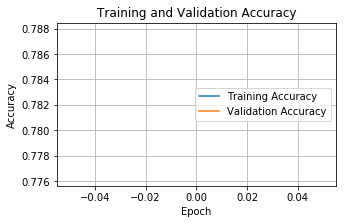


Epoch 00001: saving model to ./Plots/dfdc_model_plots_1.keras
9/9 [==============================] - 24s 3s/step - loss: 0.5803 - accuracy: 0.7762 - val_loss: 0.4240 - val_accuracy: 0.7879
Epoch 2/10
8/9 [=========================>....] - ETA: 2s - loss: 0.5339 - accuracy: 0.8164

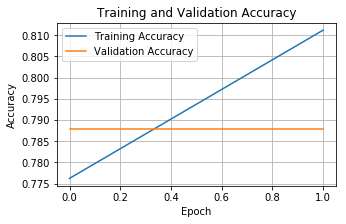


Epoch 00002: saving model to ./Plots/dfdc_model_plots_2.keras
9/9 [==============================] - 20s 2s/step - loss: 0.5322 - accuracy: 0.8112 - val_loss: 0.3774 - val_accuracy: 0.7879
Epoch 3/10
8/9 [=========================>....] - ETA: 2s - loss: 0.4995 - accuracy: 0.8086

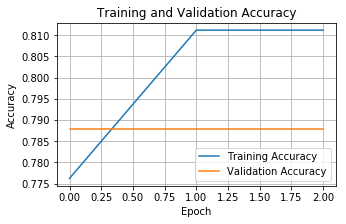


Epoch 00003: saving model to ./Plots/dfdc_model_plots_3.keras
9/9 [==============================] - 21s 2s/step - loss: 0.4968 - accuracy: 0.8112 - val_loss: 0.3686 - val_accuracy: 0.7879
Epoch 4/10
8/9 [=========================>....] - ETA: 2s - loss: 0.5156 - accuracy: 0.8086

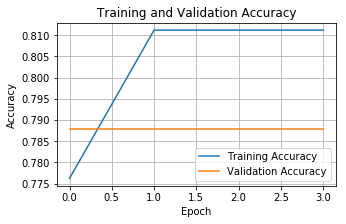


Epoch 00004: saving model to ./Plots/dfdc_model_plots_4.keras
9/9 [==============================] - 20s 2s/step - loss: 0.5107 - accuracy: 0.8112 - val_loss: 0.3955 - val_accuracy: 0.7879
Epoch 5/10
8/9 [=========================>....] - ETA: 2s - loss: 0.5130 - accuracy: 0.8203

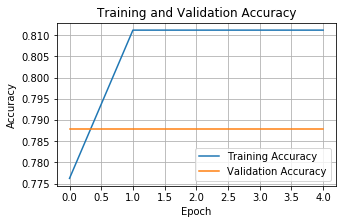


Epoch 00005: saving model to ./Plots/dfdc_model_plots_5.keras
9/9 [==============================] - 20s 2s/step - loss: 0.5158 - accuracy: 0.8112 - val_loss: 0.3851 - val_accuracy: 0.7879
Epoch 6/10
8/9 [=========================>....] - ETA: 2s - loss: 0.5492 - accuracy: 0.7969

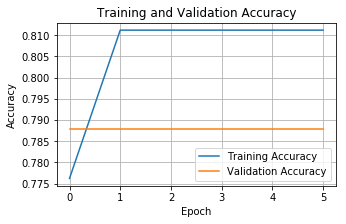


Epoch 00006: saving model to ./Plots/dfdc_model_plots_6.keras
9/9 [==============================] - 21s 2s/step - loss: 0.5299 - accuracy: 0.8112 - val_loss: 0.3892 - val_accuracy: 0.7879
Epoch 7/10
8/9 [=========================>....] - ETA: 2s - loss: 0.5033 - accuracy: 0.8125

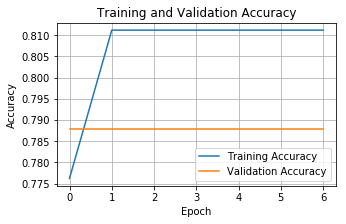


Epoch 00007: saving model to ./Plots/dfdc_model_plots_7.keras
9/9 [==============================] - 20s 2s/step - loss: 0.5000 - accuracy: 0.8112 - val_loss: 0.3785 - val_accuracy: 0.7879
Epoch 8/10
8/9 [=========================>....] - ETA: 2s - loss: 0.4791 - accuracy: 0.8203

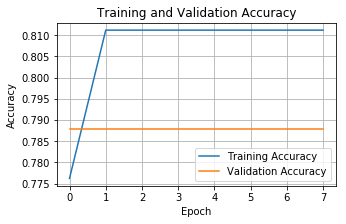


Epoch 00008: saving model to ./Plots/dfdc_model_plots_8.keras
9/9 [==============================] - 21s 2s/step - loss: 0.4916 - accuracy: 0.8112 - val_loss: 0.3734 - val_accuracy: 0.7879
Epoch 9/10
8/9 [=========================>....] - ETA: 2s - loss: 0.4987 - accuracy: 0.8203

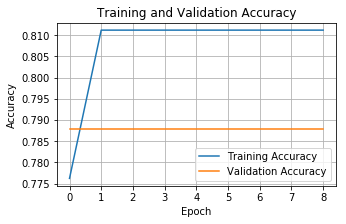


Epoch 00009: saving model to ./Plots/dfdc_model_plots_9.keras
9/9 [==============================] - 21s 2s/step - loss: 0.5155 - accuracy: 0.8112 - val_loss: 0.3896 - val_accuracy: 0.7879
Epoch 10/10
8/9 [=========================>....] - ETA: 2s - loss: 0.5206 - accuracy: 0.8164

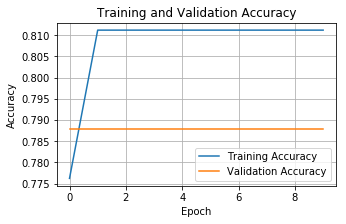


Epoch 00010: saving model to ./Plots/dfdc_model_plots_10.keras
1/3 [=========>....................] - ETA: 1s - loss: 0.4902 - accuracy: 0.8148Test loss: 0.16339061657587686
Test accuracy: 0.8148148


In [47]:
history = model.fit(train_data,
                         steps_per_epoch=train_steps_per_epoch,
                         epochs=10,
                         batch_size=batch_size,
                         validation_data=val_data,
                         validation_steps=val_steps_per_epoch,
                         callbacks=[accuracy_plot_callback, checkpoint, test_callback, metrics_plot_callback]
                         )

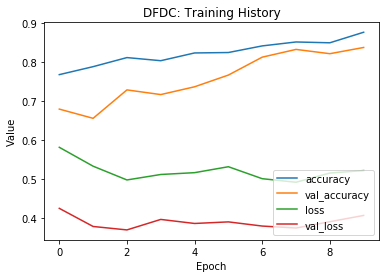

In [58]:
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('DFDC: Training History')
plt.savefig('dfdc_history3.png')
plt.show()

## Happiness

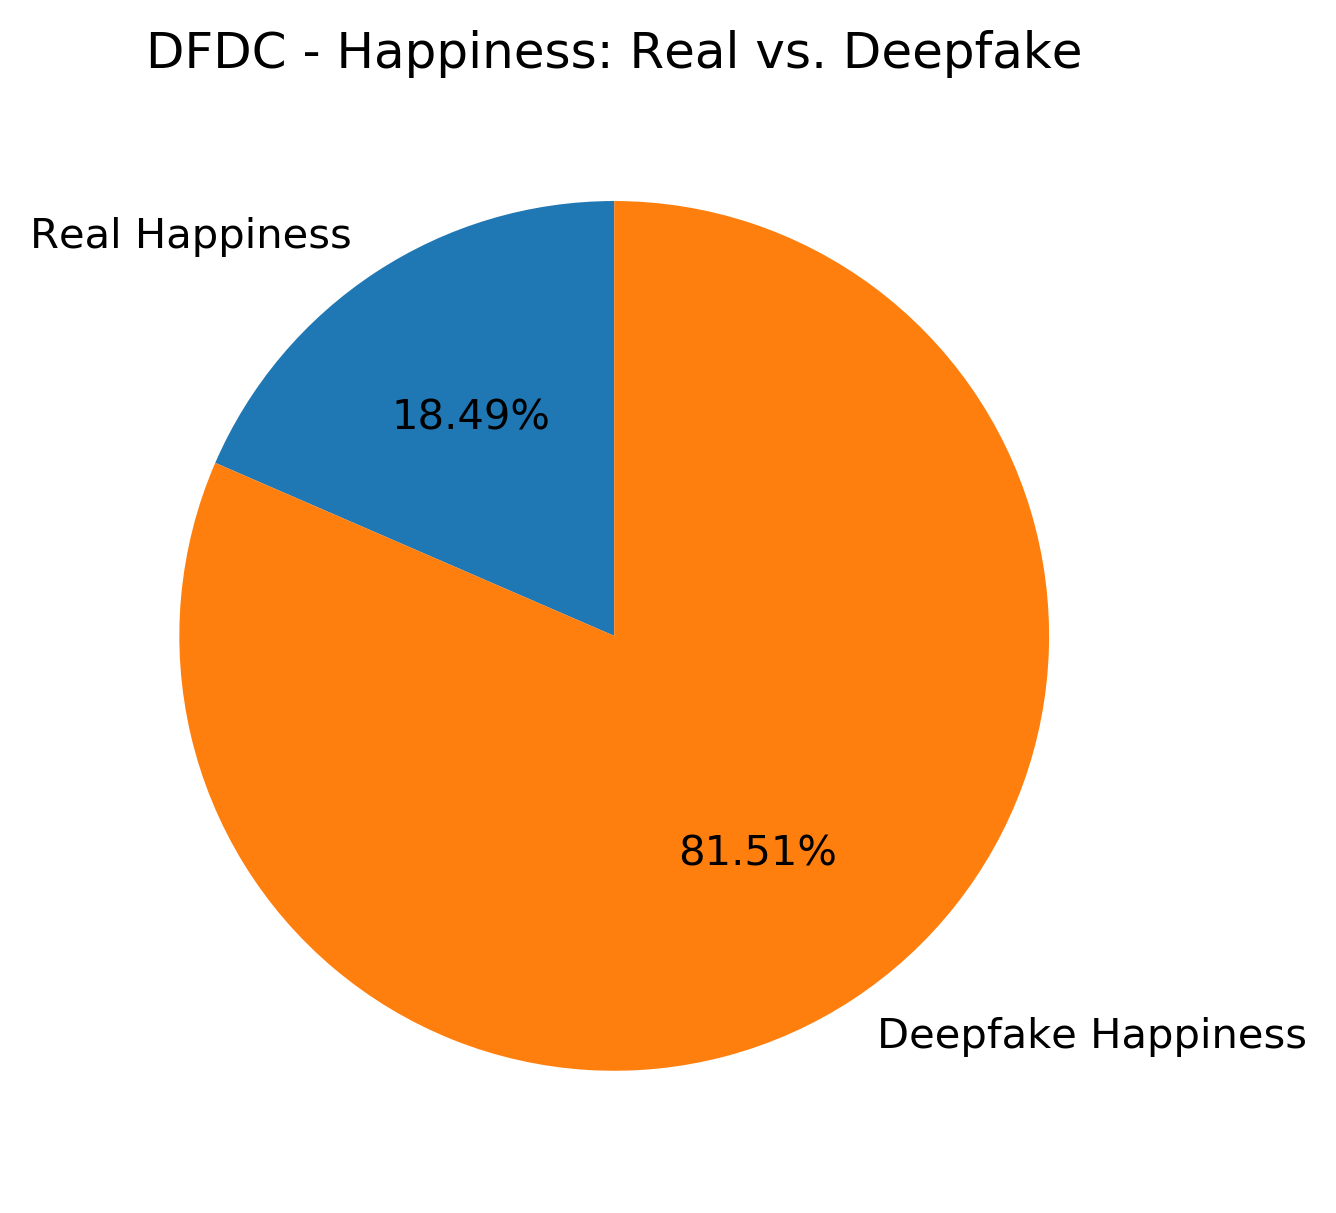

In [78]:
real_happiness = emotion_df[(emotion_df["major_emotion"] == 'happiness') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_happiness = emotion_df[(emotion_df["major_emotion"] == 'happiness') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

sizes = [len(real_happiness), len(fake_happiness)]
labels = ["Real Happiness", "Deepfake Happiness"]

plt.figure(dpi=300)
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("DFDC - Happiness: Real vs. Deepfake")
plt.savefig('DFDC happiness real vs fake.png',bbox_inches='tight')
plt.show()

In [ ]:
happy_train, happy_test, happy_val = split_files(real_happiness, fake_happiness)

In [ ]:
happy_train_data = setup_dataset(happy_train, True)
happy_val_data = setup_dataset(happy_val, False)
happy_test_data = setup_dataset(happy_test, False)

In [ ]:
happy_train_aug = happy_train_data.repeat()
happy_val_aug = happy_val_data.repeat()

In [ ]:

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = np.ceil(len(happy_train) / batch_size).astype(int)
val_steps_per_epoch = np.ceil(len(happy_val) / batch_size).astype(int)
test_steps_per_epoch = np.ceil(len(happy_test) / batch_size).astype(int)

# Calculate the number of samples in each set
num_train_samples = len(happy_train)
num_val_samples = len(happy_val)
num_test_samples = len(happy_test)

# Print the number of samples in each set
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)

print("train_steps_per_epoch:", train_steps_per_epoch)
print("val_steps_per_epoch", val_steps_per_epoch)
print("test_steps_per_epoch", test_steps_per_epoch)

In [ ]:
# Callback for testing

class TestCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_loss, test_acc = model.evaluate(happy_test_data, steps=test_steps_per_epoch)
        print('Test loss:', test_loss)
        print('Test accuracy:', test_acc)

In [ ]:
class AccuracyPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(AccuracyPlotCallback, self).__init__()
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
from sklearn.metrics import classification_report

class MetricsPlotCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_iterator = iter(happy_test_data)
        y_true = []
        y_pred = []
        for _ in range(test_steps_per_epoch):
            X_test, y_test = next(test_iterator)
            y_true.extend(y_test)
            y_pred.extend((model.predict(X_test) > 0.5).astype(int).flatten())
        cm = confusion_matrix(y_true, y_pred)
        labels = ['Real', 'Deepfake']
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1 = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels=labels)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('True')
        ax1.set_title('Confusion Matrix')
#         ax1.savefig('DFDC_happy_confusion.png')
        
#         report = classification_report(y_true, y_pred, target_names=labels)
#         ax2.text(0, 0.5, report, fontsize=12, verticalalignment='center')
#         ax2.axis('off')
#         ax2.set_title('Classification Report')

In [ ]:
# checkpoint = ModelCheckpoint(filepath='./Plots/dfdc_model_plots_{epoch}.keras', monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')
        
metrics_plot_callback = MetricsPlotCallback()

test_callback = TestCallback()

accuracy_plot_callback = AccuracyPlotCallback()

In [ ]:
happy_history = model.fit(happy_train_aug,
                         steps_per_epoch=train_steps_per_epoch,
                         epochs=10,
                         batch_size=batch_size,
                         validation_data=happy_val_aug,
                         validation_steps=val_steps_per_epoch,
                         callbacks=[test_callback, accuracy_plot_callback, metrics_plot_callback]
                         )

In [ ]:
plt.plot(happy_history.history['accuracy'], label='accuracy')
plt.plot(happy_history.history['val_accuracy'], label='val_accuracy')
plt.plot(happy_history.history['loss'], label='loss')
plt.plot(happy_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('DFDC: Happiness Training History')
plt.savefig('dfdc_happy_history.png')
plt.show()


## Sadness

In [56]:
real_sadness = emotion_df[(emotion_df["major_emotion"] == 'sadness') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_sadness = emotion_df[(emotion_df["major_emotion"] == 'sadness') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

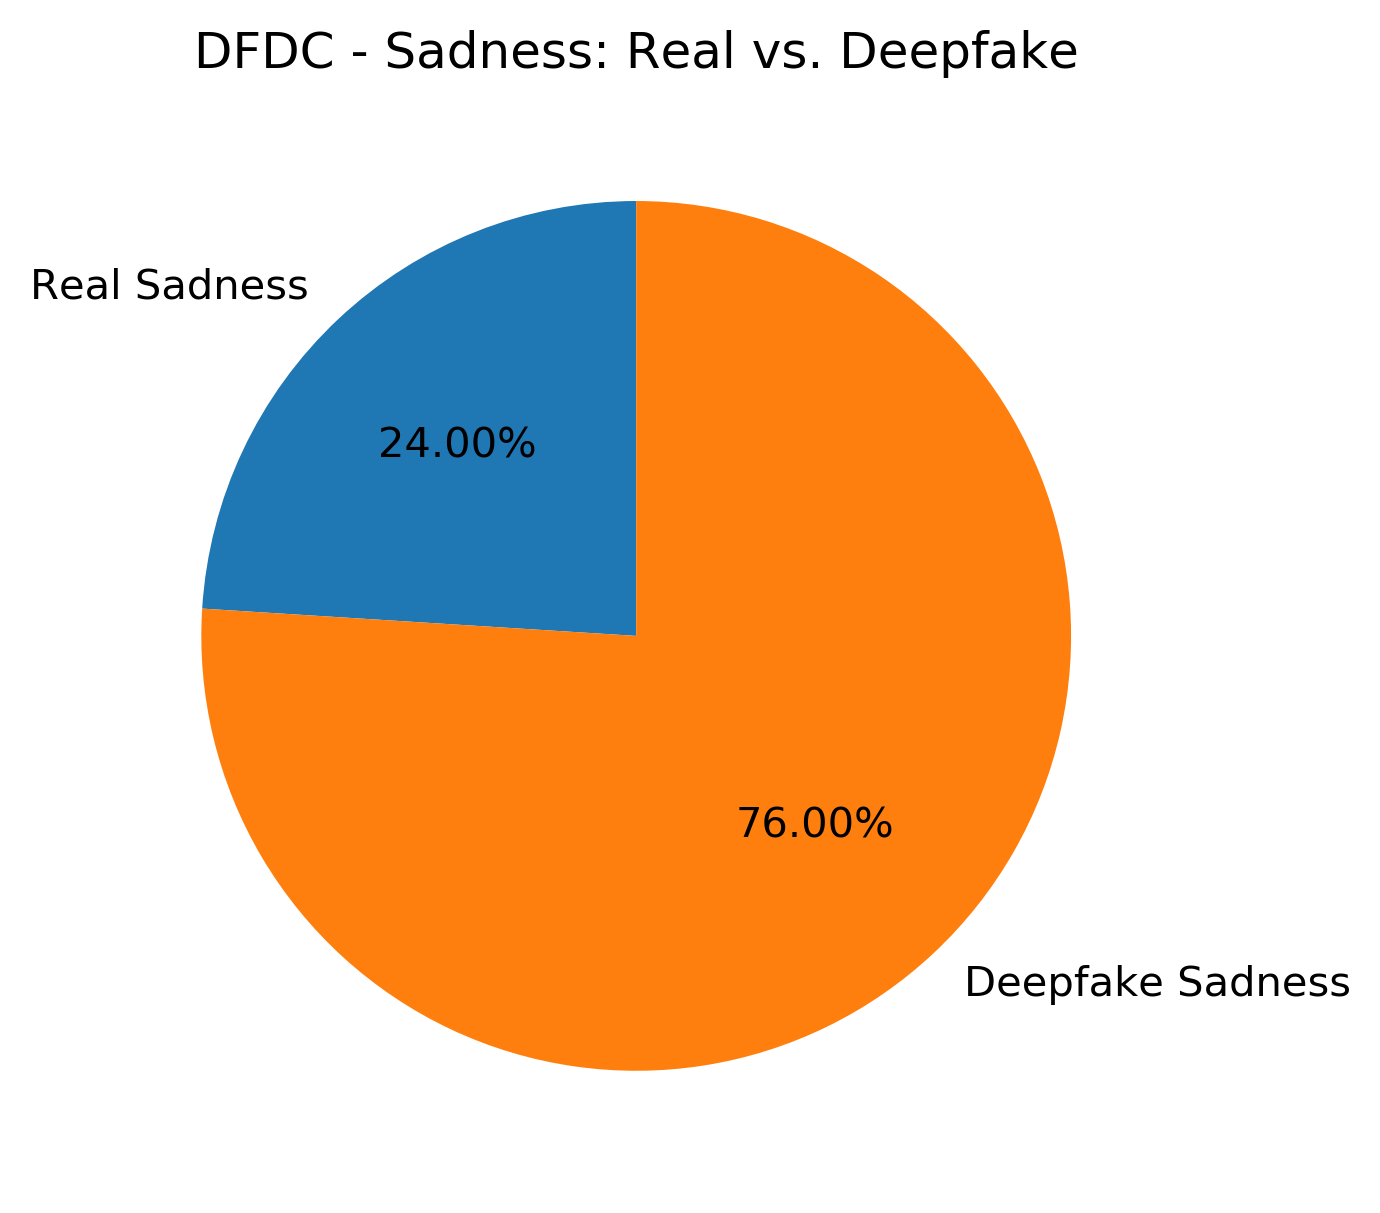

In [77]:
sizes = [len(real_sadness), len(fake_sadness)]
labels = ["Real Sadness", "Deepfake Sadness"]
plt.figure(dpi=300)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("DFDC - Sadness: Real vs. Deepfake")
plt.savefig('DFDC sadness real vs fake.png',bbox_inches='tight')
plt.show()

In [ ]:
sad_train, sad_test, sad_val = split_files(real_sadness, fake_sadness)

In [ ]:
sad_train_data = setup_dataset(sad_train, True)
sad_val_data = setup_dataset(sad_val, False)
sad_test_data = setup_dataset(sad_test, False)

In [ ]:

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = np.ceil(len(sad_train) / batch_size).astype(int)
val_steps_per_epoch = np.ceil(len(sad_val) / batch_size).astype(int)
test_steps_per_epoch = np.ceil(len(sad_test) / batch_size).astype(int)

# Calculate the number of samples in each set
num_train_samples = len(sad_train)
num_val_samples = len(sad_val)
num_test_samples = len(sad_test)

# Print the number of samples in each set
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)

print("train_steps_per_epoch:", train_steps_per_epoch)
print("val_steps_per_epoch", val_steps_per_epoch)
print("test_steps_per_epoch", test_steps_per_epoch)

In [ ]:
# Callback for testing

class TestCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_loss, test_acc = model.evaluate(sad_test_data, steps=test_steps_per_epoch)
        print('Test loss:', test_loss)
        print('Test accuracy:', test_acc)

In [ ]:
class AccuracyPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(AccuracyPlotCallback, self).__init__()
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
from sklearn.metrics import classification_report

class MetricsPlotCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_iterator = iter(sad_test_data)
        y_true = []
        y_pred = []
        for _ in range(test_steps_per_epoch):
            X_test, y_test = next(test_iterator)
            y_true.extend(y_test)
            y_pred.extend((model.predict(X_test) > 0.5).astype(int).flatten())
        cm = confusion_matrix(y_true, y_pred)
        labels = ['Real', 'Deepfake']
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1 = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels=labels)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('True')
        ax1.set_title('Confusion Matrix')
#         ax1.savefig('DFDC_happy_confusion.png')
        
        report = classification_report(y_true, y_pred, target_names=labels)
        ax2.text(0, 0.5, report, fontsize=12, verticalalignment='center')
        ax2.axis('off')
        ax2.set_title('Classification Report')

In [ ]:
# checkpoint = ModelCheckpoint(filepath='./Plots/dfdc_model_plots_{epoch}.keras', monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')
        
metrics_plot_callback = MetricsPlotCallback()

test_callback = TestCallback()

accuracy_plot_callback = AccuracyPlotCallback()

In [ ]:
sad_history = model.fit(sad_train_data.repeat(),
                         steps_per_epoch=train_steps_per_epoch,
                         epochs=10,
                         batch_size=batch_size,
                         validation_data=sad_val_data.repeat(),
                         validation_steps=val_steps_per_epoch,
                         callbacks=[test_callback, accuracy_plot_callback, metrics_plot_callback]
                         )

In [ ]:
plt.plot(sad_history.history['accuracy'], label='accuracy')
plt.plot(sad_history.history['val_accuracy'], label='val_accuracy')
plt.plot(sad_history.history['loss'], label='loss')
plt.plot(sad_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('DFDC: Sadness Training History')
plt.savefig('dfdc_sad_history.png')
plt.show()


## Anger

In [58]:
real_anger = emotion_df[(emotion_df["major_emotion"] == 'anger') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_anger = emotion_df[(emotion_df["major_emotion"] == 'anger') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

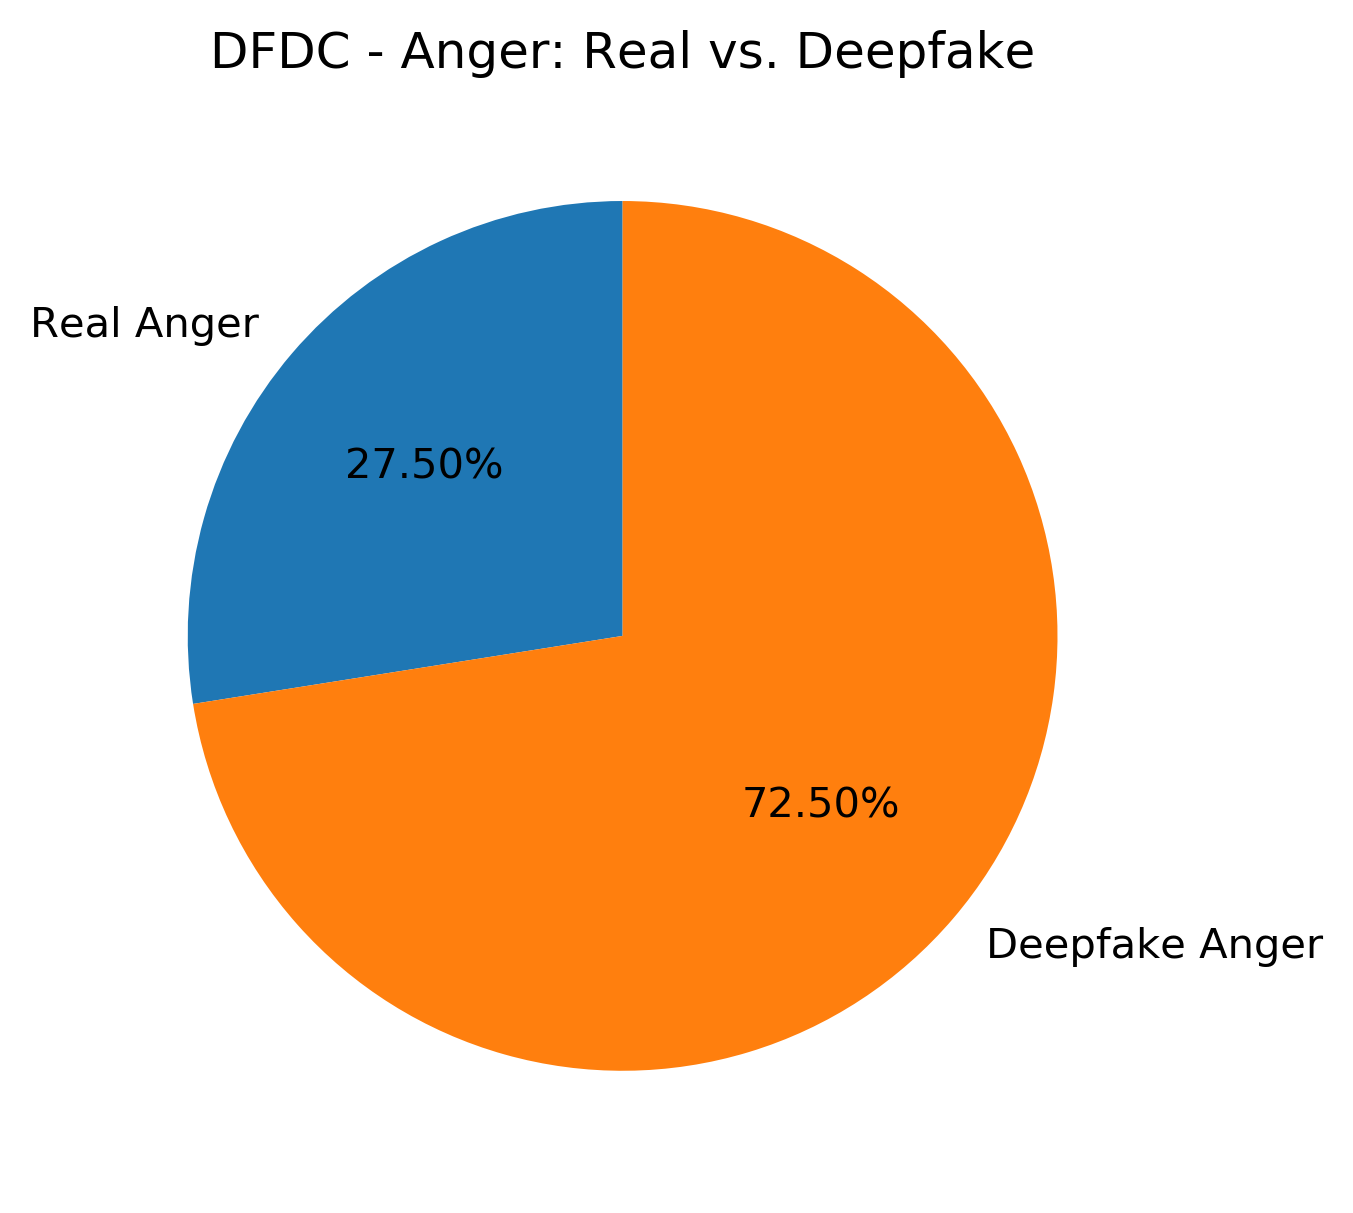

In [75]:
plt.figure( dpi=300)

sizes = [len(real_anger), len(fake_anger)]
labels = ["Real Anger", "Deepfake Anger"]

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("DFDC - Anger: Real vs. Deepfake")
plt.savefig('DFDC anger real vs fake.png',bbox_inches='tight')
plt.show()

## Fear

In [60]:
real_fear = emotion_df[(emotion_df["major_emotion"] == 'fear') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_fear = emotion_df[(emotion_df["major_emotion"] == 'fear') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

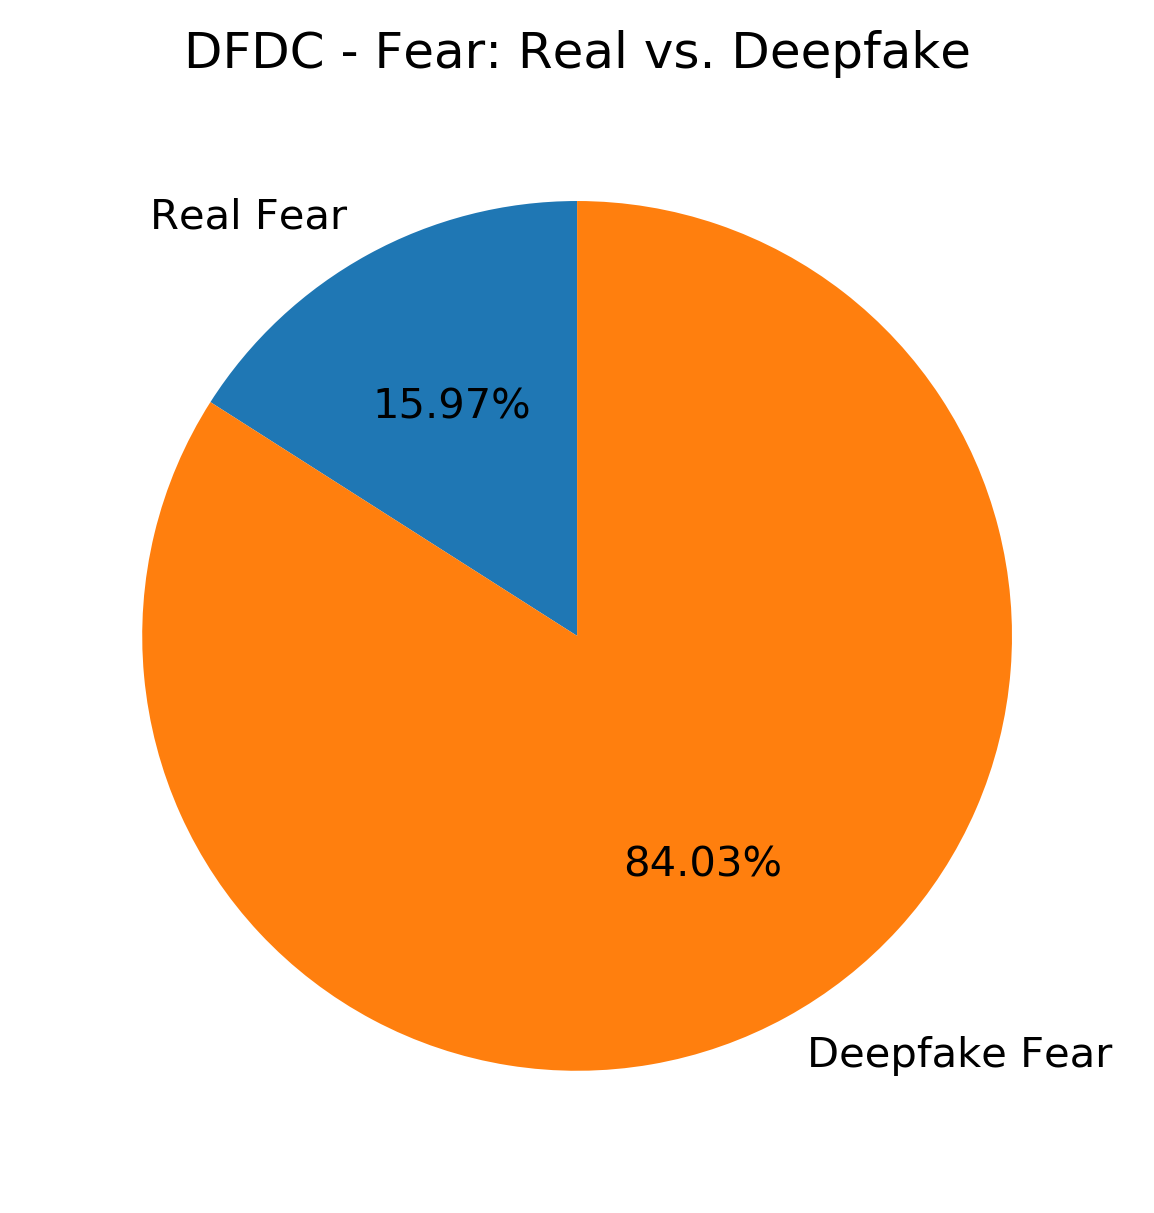

In [76]:

sizes = [len(real_fear), len(fake_fear)]
labels = ["Real Fear", "Deepfake Fear"]
plt.figure (dpi=300)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("DFDC - Fear: Real vs. Deepfake")
plt.savefig('DFDC fear real vs fake.png',bbox_inches='tight')
plt.show()

In [ ]:
fear_train, fear_test, fear_val = split_files(real_fear, fake_fear)

In [ ]:
fear_train_data = setup_dataset(fear_train, True)
fear_val_data = setup_dataset(fear_val, False)
fear_test_data = setup_dataset(fear_test, False)

In [ ]:

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = np.ceil(len(fear_train) / batch_size).astype(int)
val_steps_per_epoch = np.ceil(len(fear_val) / batch_size).astype(int)
test_steps_per_epoch = np.ceil(len(fear_test) / batch_size).astype(int)

# Calculate the number of samples in each set
num_train_samples = len(fear_train)
num_val_samples = len(fear_val)
num_test_samples = len(fear_test)

# Print the number of samples in each set
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)

print("train_steps_per_epoch:", train_steps_per_epoch)
print("val_steps_per_epoch", val_steps_per_epoch)
print("test_steps_per_epoch", test_steps_per_epoch)

In [ ]:
# Callback for testing

class TestCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_loss, test_acc = model.evaluate(fear_test_data, steps=test_steps_per_epoch)
        print('Test loss:', test_loss)
        print('Test accuracy:', test_acc)

In [ ]:
class AccuracyPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(AccuracyPlotCallback, self).__init__()
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
from sklearn.metrics import classification_report

class MetricsPlotCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_iterator = iter(fear_test_data)
        y_true = []
        y_pred = []
        for _ in range(test_steps_per_epoch):
            X_test, y_test = next(test_iterator)
            y_true.extend(y_test)
            y_pred.extend((model.predict(X_test) > 0.5).astype(int).flatten())
        cm = confusion_matrix(y_true, y_pred)
        labels = ['Real', 'Deepfake']
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1 = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels=labels)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('True')
        ax1.set_title('Confusion Matrix')
#         ax1.savefig('DFDC_happy_confusion.png')
        
        report = classification_report(y_true, y_pred, target_names=labels)
        ax2.text(0, 0.5, report, fontsize=12, verticalalignment='center')
        ax2.axis('off')
        ax2.set_title('Classification Report')

In [ ]:
# checkpoint = ModelCheckpoint(filepath='./Plots/dfdc_model_plots_{epoch}.keras', monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')
        
metrics_plot_callback = MetricsPlotCallback()

test_callback = TestCallback()

accuracy_plot_callback = AccuracyPlotCallback()

In [ ]:
fear_history = model.fit(fear_train_data.repeat(),
                         steps_per_epoch=train_steps_per_epoch,
                         epochs=10,
                         batch_size=batch_size,
                         validation_data=fear_val_data.repeat(),
                         validation_steps=val_steps_per_epoch
                         callbacks=[test_callback, accuracy_plot_callback, metrics_plot_callback]
                         )

In [ ]:
plt.plot(fear_history.history['accuracy'], label='accuracy')
plt.plot(fear_history.history['val_accuracy'], label='val_accuracy')
plt.plot(fear_history.history['loss'], label='loss')
plt.plot(fear_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('DFDC: Fear Training History')
plt.savefig('dfdc_fear_history.png')
plt.show()


## Disgust

In [65]:
real_disgust = emotion_df[(emotion_df["major_emotion"] == 'disgust') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_disgust = emotion_df[(emotion_df["major_emotion"] == 'disgust') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

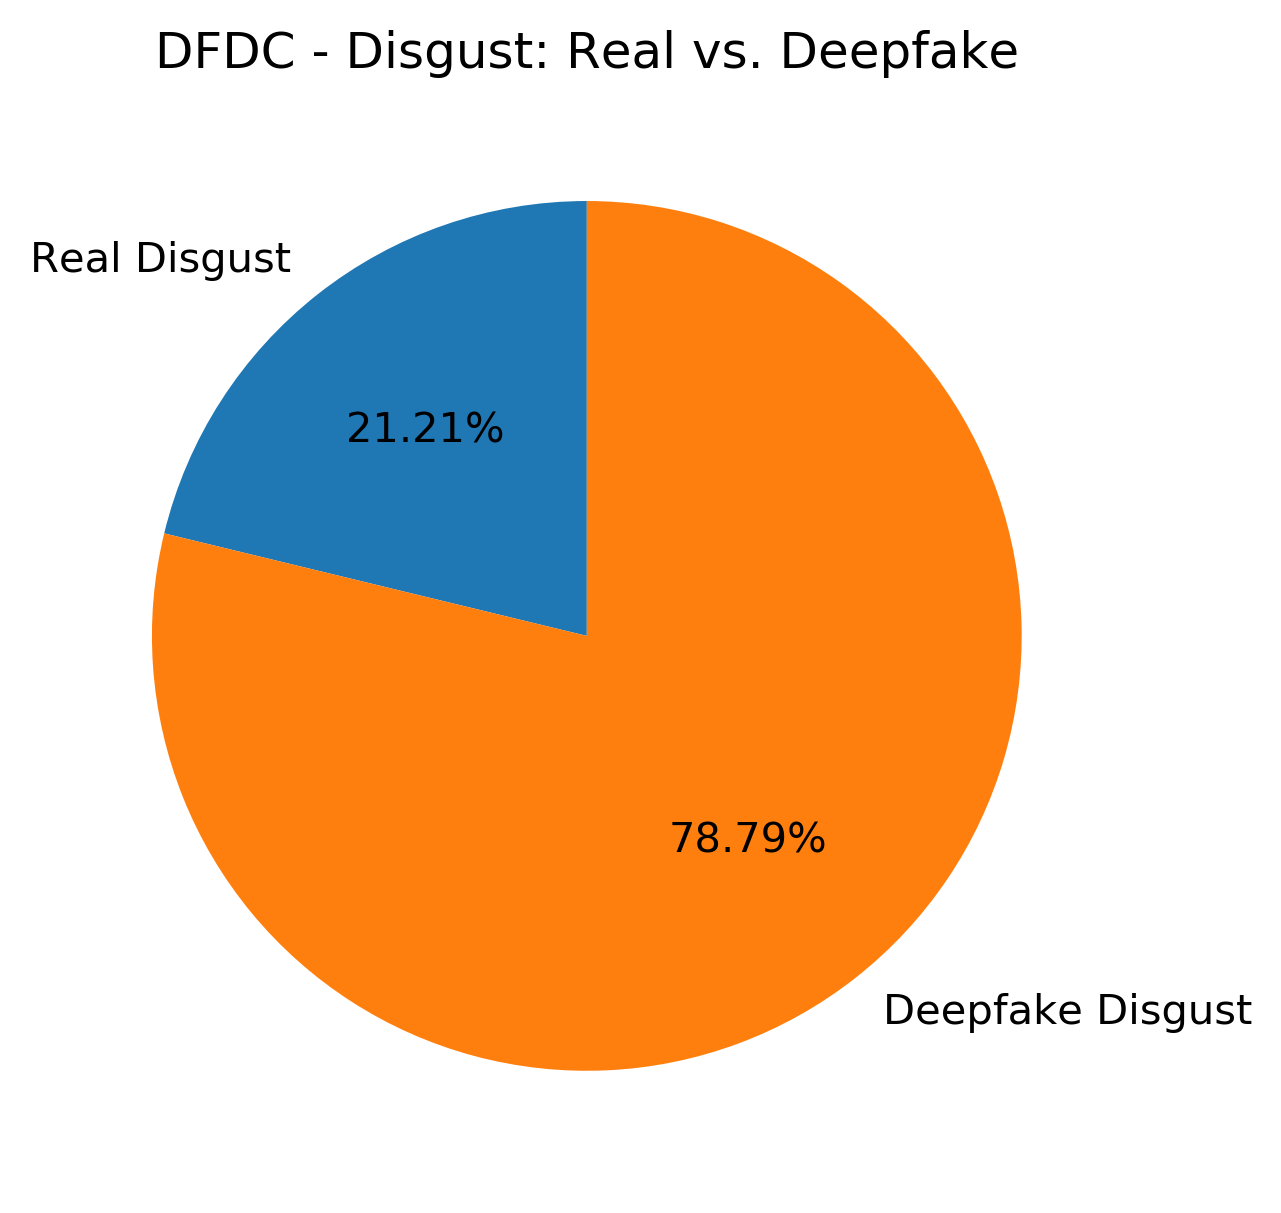

In [79]:

sizes = [len(real_disgust), len(fake_disgust)]
labels = ["Real Disgust", "Deepfake Disgust"]
plt.figure(dpi=300)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("DFDC - Disgust: Real vs. Deepfake")
plt.savefig('DFDC disgust real vs fake.png',bbox_inches='tight')
plt.show()

## Surprise

In [67]:
real_surprise = emotion_df[(emotion_df["major_emotion"] == 'surprise') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_surprise = emotion_df[(emotion_df["major_emotion"] == 'surprise') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

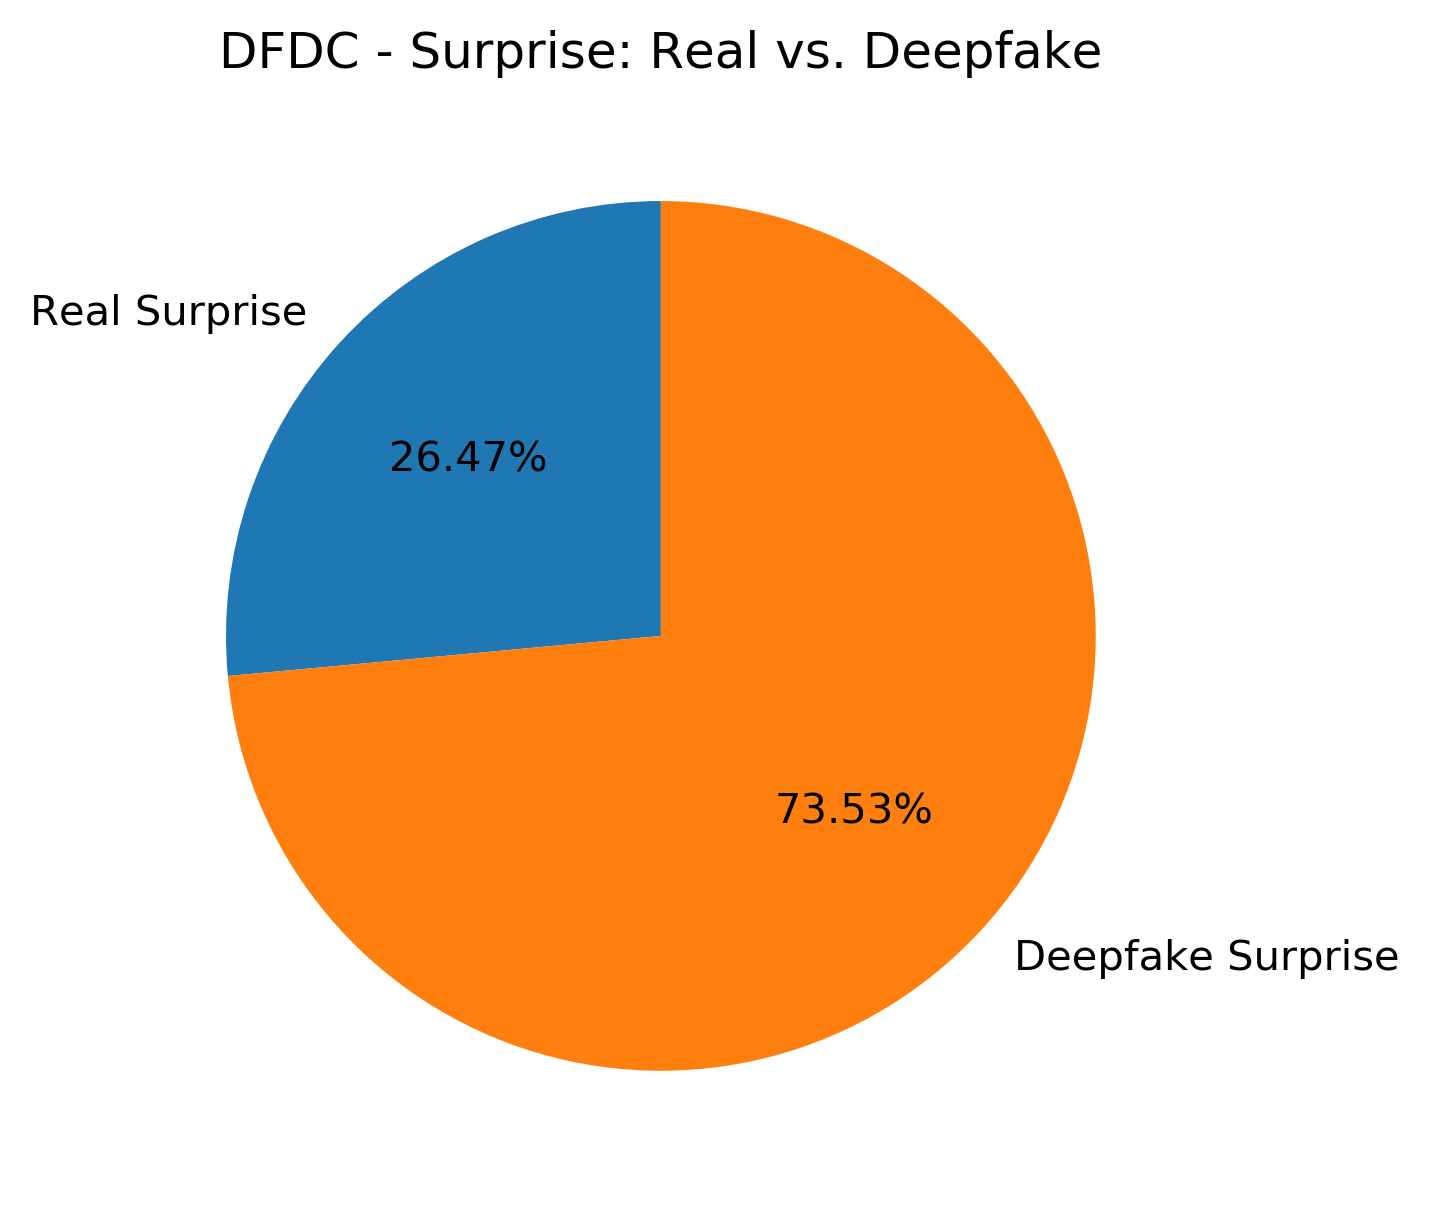

In [80]:
# plt.figure(figsize=(3.89,4.11), dpi=100)
# plt.set_size_inches(5, 8)
plt.figure(dpi=300)


sizes = [len(real_surprise), len(fake_surprise)]
labels = ["Real Surprise", "Deepfake Surprise"]

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("DFDC - Surprise: Real vs. Deepfake")
plt.savefig('DFDC surprise real vs fake.png',bbox_inches='tight')
plt.show()